In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

%matplotlib inline

Let's check if PyTorch is using GPU

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')
print(torch.cuda.get_device_name(0))

device: cuda
NVIDIA GeForce RTX 3060


## Data Exploration

The CSV file contained the house prices, the type of house asset (such as Condominium, Bungalow, etc.)

In [3]:
df = pd.read_csv("data_kaggle.csv")
print(len(df))

53883


In [4]:
df.head()

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,"KLCC, Kuala Lumpur","RM 1,250,000",2+1,3.0,2.0,Serviced Residence,"Built-up : 1,335 sq. ft.",Fully Furnished
1,"Damansara Heights, Kuala Lumpur","RM 6,800,000",6,7.0,NaN,Bungalow,Land area : 6900 sq. ft.,Partly Furnished
2,"Dutamas, Kuala Lumpur","RM 1,030,000",3,4.0,2.0,Condominium (Corner),"Built-up : 1,875 sq. ft.",Partly Furnished
3,"Cheras, Kuala Lumpur",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Bukit Jalil, Kuala Lumpur","RM 900,000",4+1,3.0,2.0,Condominium (Corner),"Built-up : 1,513 sq. ft.",Partly Furnished


## Data Cleaning (a.k.a Pre-processing)
We noticed that there are some rows are "NaN", which containing meaningless values.
Before make our hands wet, these values must be replace by mean either its mode or mean
corresponding to its location.

In [5]:
import re
import locale
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

non_decimal = re.compile(r'[^\dx]+')

df['Price'] = df['Price'].apply(lambda x: non_decimal.sub('', str(x)))
df['Price'] = df['Price'].apply(lambda x: int(x) / 1000000 if x != '' else np.nan)

In [6]:
pattern = re.compile(r"[A-Za-z] : (.,?[\d.]+)[xX~]?(\d+)? sq. ft.")

def check_none(val):
    if not (val is None):
        return locale.atof(str(val))
    else:
        return 1

def format_size_col(x: str):
    m = re.search(pattern, str(x))
    if m:
        result = locale.atof(m.groups()[0]) * check_none(m.groups()[1])
        return result / 1000
    else:
        return float('nan')

df['Size'] = df['Size'].apply(lambda x: format_size_col(x))

In [7]:
def format_room_col(x):
    return eval(str(x) if type(x) == str and x != 'Studio' else 'float("nan")')

df['Rooms'] = df['Rooms'].apply(lambda x: format_room_col(x))

In [8]:
furnishing_dict = {
    'Unfurnished': 0,
    'Partly Furnished': 1,
    'Fully Furnished': 2,
}

df['Furnishing'] = df['Furnishing'].apply(lambda x: int(furnishing_dict[x] if str(x) in furnishing_dict.keys() else 0))

In [9]:
df['Location'] = df['Location'].apply(lambda x: x.removesuffix(', Kuala Lumpur'))

### Handling missing values

When dealing with missing data, data scientists use two common methods to solve this 
problem: imputations, or just removing the row that contains missing value.

In this project, we will just drop the missing rows. 

In [10]:
df = df.dropna().reset_index(drop=True)

In [11]:
df[['Rooms', 'Bathrooms', 'Car Parks']] = df[['Rooms', 'Bathrooms', 'Car Parks']].astype('float').astype('int')
#df['Location'] = df['Location'].astype('category')

In [12]:
from sklearn.preprocessing import LabelEncoder

df['Location'] = LabelEncoder().fit_transform(df['Location'])
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,40,1.250,3,3,2,Serviced Residence,1.335,2
1,26,1.030,3,4,2,Condominium (Corner),1.875,1
2,11,0.900,5,3,2,Condominium (Corner),1.513,1
3,76,5.350,6,5,4,Bungalow,7.200,1
4,76,2.600,5,4,4,Semi-detached House,3.600,1
...,...,...,...,...,...,...,...,...
34424,46,0.585,4,3,2,Condominium,1.313,0
34425,39,1.400,4,3,2,Condominium (Corner),1.544,2
34426,38,0.880,1,1,1,Condominium (Corner),0.650,1
34427,66,2.700,6,6,3,Condominium (Corner),3.973,1


In [14]:
property_type = df['Property Type'].unique()

In [15]:
df['Property Type'] = LabelEncoder().fit_transform(df['Property Type'])
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,40,1.250,3,3,2,77,1.335,2
1,26,1.030,3,4,2,55,1.875,1
2,11,0.900,5,3,2,55,1.513,1
3,76,5.350,6,5,4,44,7.200,1
4,76,2.600,5,4,4,71,3.600,1
...,...,...,...,...,...,...,...,...
34424,46,0.585,4,3,2,54,1.313,0
34425,39,1.400,4,3,2,55,1.544,2
34426,38,0.880,1,1,1,55,0.650,1
34427,66,2.700,6,6,3,55,3.973,1


In [16]:
property_indices = df['Property Type'].unique()

In [17]:
extdict = dict(zip(property_type, property_indices))
extdict

{'Serviced Residence': 77,
 'Condominium (Corner)': 55,
 'Bungalow': 44,
 'Semi-detached House': 71,
 '2-sty Terrace/Link House (EndLot)': 11,
 'Apartment (Intermediate)': 41,
 'Bungalow (Intermediate)': 47,
 'Bungalow (Corner)': 45,
 'Serviced Residence (Intermediate)': 81,
 'Condominium': 54,
 'Condominium (Intermediate)': 58,
 'Condominium (EndLot)': 57,
 'Serviced Residence (Corner)': 78,
 '3-sty Terrace/Link House (Intermediate)': 24,
 'Serviced Residence (Duplex)': 79,
 '2-sty Terrace/Link House': 8,
 '2-sty Terrace/Link House (Corner)': 9,
 '2-sty Terrace/Link House (Intermediate)': 12,
 '2.5-sty Terrace/Link House (Intermediate)': 18,
 'Serviced Residence (Penthouse)': 82,
 '3-sty Terrace/Link House (EndLot)': 23,
 '1-sty Terrace/Link House (Intermediate)': 3,
 '1.5-sty Terrace/Link House (EndLot)': 6,
 'Apartment': 37,
 'Condominium (Duplex)': 56,
 'Serviced Residence (EndLot)': 80,
 '3.5-sty Terrace/Link House (Intermediate)': 29,
 '4-sty Terrace/Link House': 30,
 '4-sty Terr

In [20]:
import json
with open('property-type.txt', 'w') as file:
    file.write(str(extdict))

In [14]:
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,40,1.250,3,3,2,77,1.335,2
1,26,1.030,3,4,2,55,1.875,1
2,11,0.900,5,3,2,55,1.513,1
3,76,5.350,6,5,4,44,7.200,1
4,76,2.600,5,4,4,71,3.600,1
...,...,...,...,...,...,...,...,...
34424,46,0.585,4,3,2,54,1.313,0
34425,39,1.400,4,3,2,55,1.544,2
34426,38,0.880,1,1,1,55,0.650,1
34427,66,2.700,6,6,3,55,3.973,1


# Remove Outliers

In [15]:
df = df.drop(df[df['Price'] >= 5].index)
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,40,1.250,3,3,2,77,1.335,2
1,26,1.030,3,4,2,55,1.875,1
2,11,0.900,5,3,2,55,1.513,1
4,76,2.600,5,4,4,71,3.600,1
5,76,1.950,5,4,3,11,1.875,1
...,...,...,...,...,...,...,...,...
34424,46,0.585,4,3,2,54,1.313,0
34425,39,1.400,4,3,2,55,1.544,2
34426,38,0.880,1,1,1,55,0.650,1
34427,66,2.700,6,6,3,55,3.973,1


In [16]:
df = df.drop(df[df['Rooms'] >= 10].index)
df = df.drop(df[df['Car Parks'] >= 10].index)
df = df.drop(df[df['Size'] >= 30].index)
df = df.drop(df[df['Bathrooms'] >= 7].index)

In [17]:
df

,Location,Price,Rooms,Bathrooms,Car Parks,Property Type,Size,Furnishing
0,40,1.250,3,3,2,77,1.335,2
1,26,1.030,3,4,2,55,1.875,1
2,11,0.900,5,3,2,55,1.513,1
4,76,2.600,5,4,4,71,3.600,1
5,76,1.950,5,4,3,11,1.875,1
...,...,...,...,...,...,...,...,...
34424,46,0.585,4,3,2,54,1.313,0
34425,39,1.400,4,3,2,55,1.544,2
34426,38,0.880,1,1,1,55,0.650,1
34427,66,2.700,6,6,3,55,3.973,1


## Building Machine Learning Model

In [18]:
cat_feat = ["Location", "Rooms", "Bathrooms", "Car Parks", "Property Type", "Furnishing"]
cont_feat = 'Size'
out_feat = "Price"

In [19]:
train_size = int(len(df) * 0.8)
train_size

25912

In [20]:
train_set = df[:train_size]
test_set = df[train_size:]

In [21]:
X = train_set.drop(columns=['Price'])
y = train_set[out_feat]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [23]:
cat_dims = [len(X[col].unique()) for col in cat_feat]
cat_dims

[77, 9, 6, 9, 85, 3]

In [24]:
embedding_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
embedding_dims

[(77, 39), (9, 5), (6, 3), (9, 5), (85, 43), (3, 2)]

In [25]:
from torch.utils.data import Dataset, DataLoader

class HousePriceDataset(Dataset):
    def __init__(self, X, Y, cat_col_names, cont_col_names, device):
        X = X.copy()
        self.X_cat = torch.tensor(X[cat_col_names].to_numpy(), dtype=torch.int64).to(device) #categorical columns
        print(X[cat_col_names].iloc[0].to_numpy())
        self.X_cont = torch.tensor(X[cont_col_names].to_numpy(), dtype=torch.float32).reshape(-1, 1).to(device) #numerical columns
        # print(X[cont_col_names].iloc[0])
        self.y = torch.tensor(Y.to_numpy(), dtype=torch.float32).reshape(-1, 1).to(device)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_cont[idx], self.y[idx]

In [26]:
train_ds = HousePriceDataset(X_train, y_train, cat_col_names=cat_feat, cont_col_names=cont_feat, device=device)
test_ds = HousePriceDataset(X_test, y_test, cat_col_names=cat_feat, cont_col_names=cont_feat, device=device)

[32  2  2  2 78  0]
[ 5  3  3  2 77  2]


In [27]:
train_dl = DataLoader(train_ds, batch_size=1200, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1200, shuffle=True)

In [28]:
class SparseTabularNN(nn.Module):
    def __init__(self, embedding_dim, n_cont, out_sz, layers, dropout_rate=0.5) -> None:
        super().__init__()
        self.embeds = nn.ModuleList([
            nn.Embedding(inp, out) for inp, out in embedding_dim
        ])
        self.emb_drop = nn.Dropout(dropout_rate)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum(e.embedding_dim for e in self.embeds)
        n_in = n_emb + n_cont

        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(dropout_rate))
            n_in = i
        
        layer_list.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x_cat, x_cont):
        embeddings = [e(torch.clamp(x_cat[:,i], 0, e.num_embeddings - 1)) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x2 = self.bn_cont(x_cont)
        x = torch.cat([x, x2], 1)
        x = self.layers(x)

        return x

In [29]:
model = SparseTabularNN(embedding_dims, 1, 1, [240, 70], dropout_rate=0.40).to(device)

In [30]:
loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
# optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0.00001)

/home/pehcy/miniconda3/envs/nphouse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x_cat, x_cont, y in valid_dl:
        batch_size = y.shape[0]
        pred = model(x_cat, x_cont)
        loss = torch.sqrt(F.mse_loss(pred, y))

        sum_loss += batch_size * (loss.item())
        total += batch_size
    
    print("validation loss: %.3f" % (sum_loss/total))

In [32]:
final_losses = []

for i in range(1200):
    model.train()
    total, sum_loss = 0, 0
    for x_cat, x_cont, y in train_dl:
        batch = y.shape[0]
        y_pred = model(x_cat, x_cont)
        loss = torch.sqrt(F.mse_loss(y_pred, y))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += batch
        sum_loss += batch*(loss.item())

    mean_loss = sum_loss / total
    if (i+1) % 100 == 1:
        print("Epoch number: {} and the loss : {}".format(i, loss.item()))
    
    final_losses.append(mean_loss)

Epoch number: 0 and the loss : 1.3724400997161865
Epoch number: 100 and the loss : 0.4053935706615448
Epoch number: 200 and the loss : 0.3265203535556793
Epoch number: 300 and the loss : 0.37974002957344055
Epoch number: 400 and the loss : 0.3872787654399872
Epoch number: 500 and the loss : 0.40499481558799744
Epoch number: 600 and the loss : 0.3564997911453247
Epoch number: 700 and the loss : 0.3676145672798157
Epoch number: 800 and the loss : 0.3239438235759735
Epoch number: 900 and the loss : 0.3437061607837677
Epoch number: 1000 and the loss : 0.3144705891609192
Epoch number: 1100 and the loss : 0.36438292264938354


In [33]:
final_losses

[1.53370629780153,
 1.3744191967910206,
 1.284734719355928,
 1.211001776005334,
 1.1100345323500882,
 1.0081162791940168,
 0.8987790878616474,
 0.8172041655961244,
 0.7590256351034987,
 0.7170094394454954,
 0.6747225405418946,
 0.6525264049675916,
 0.6233240542072964,
 0.6052495276676636,
 0.5850538484490874,
 0.5771055301695658,
 0.5636079103794058,
 0.5528864474739155,
 0.545416287897039,
 0.532375916758853,
 0.5274671442809237,
 0.5211663878086513,
 0.5134202770860411,
 0.5030381295033339,
 0.5000010582778944,
 0.4972782848675394,
 0.4890955385943732,
 0.49060603796967067,
 0.4891119671630482,
 0.47762809678070384,
 0.47900418867405375,
 0.47072816198006384,
 0.4719802159146592,
 0.4741466134143949,
 0.4625736815785987,
 0.4650074076986651,
 0.4615340613727661,
 0.4611302787427522,
 0.46247734869347107,
 0.45521774966250145,
 0.4537538529345266,
 0.45036313162882136,
 0.4497372131785526,
 0.45348841598458434,
 0.4449585777968837,
 0.4453768067220409,
 0.4496333306056211,
 0.44388051

Text(0.5, 0, 'epoch')

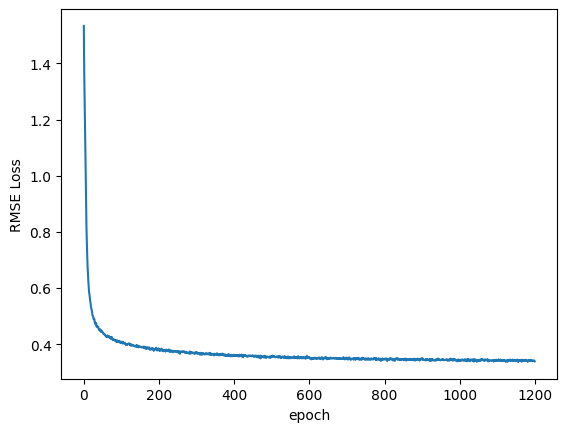

In [34]:
plt.plot(range(1200), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [35]:
torch.save(model,'HousePrice.pt')

In [36]:
torch.save(model.state_dict(), 'HouseWeights.pt')

In [37]:
emb_size = [(77, 39), (9, 5), (6, 3), (9, 5), (85, 43), (3, 2)]
model2 = SparseTabularNN(emb_size, 1, 1, [240, 70], dropout_rate=0.40).to(device)

In [38]:
model2.load_state_dict(torch.load('HouseWeights.pt'))

<All keys matched successfully>

In [39]:
model2.eval()

SparseTabularNN(
  (embeds): ModuleList(
    (0): Embedding(77, 39)
    (1): Embedding(9, 5)
    (2): Embedding(6, 3)
    (3): Embedding(9, 5)
    (4): Embedding(85, 43)
    (5): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=98, out_features=240, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=240, out_features=70, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=70, out_features=1, bias=True)
  )
)

In [45]:
X2_cat = torch.tensor(np.array([[5,  3,  3,  2, 77,  2]]), dtype=torch.int64).to(device)
X2_cont = torch.tensor(np.array([[1.875]]), dtype=torch.float32).reshape(-1, 1).to(device)

with torch.no_grad():
    y_pred = model2(X2_cat, X2_cont)
    print(y_pred.item())

1.5153321027755737
